In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# 1. Import and Install Dependencies

## 1.1 Install Dependencies

In [2]:
!pip install tensorflow tensorflow-gpu tensorflow-io matplotlib

## 1.2 Load Dependencies

In [3]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

# 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [4]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

## 2.2 Build Dataloading Function

In [5]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## 2.3 Plot Wave

In [6]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

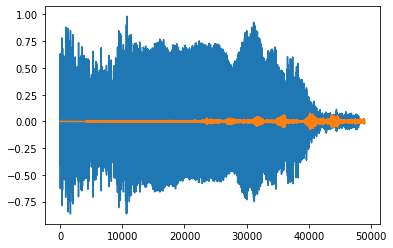

In [7]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [8]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

## 3.2 Create Tensorflow Datasets

In [9]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

## 3.3 Add labels and Combine Positive and Negative Samples

In [10]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [11]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [12]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [13]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [14]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [15]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [16]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [17]:
spectrogram, label = preprocess(filepath, label)

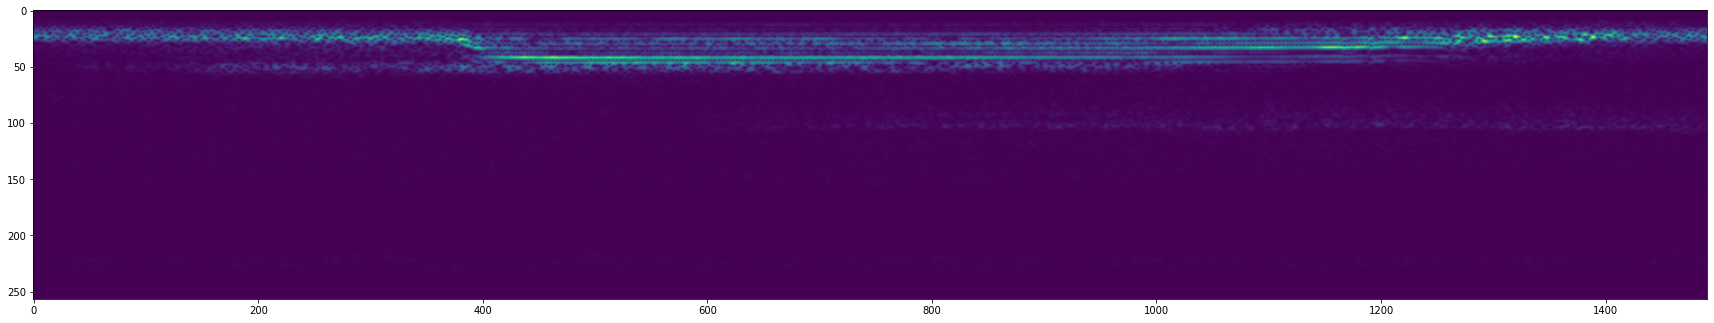

In [18]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [19]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

## 6.2 Split into Training and Testing Partitions

In [20]:
train = data.take(36)
test = data.skip(36).take(15)

## 6.3 Test One Batch

In [21]:
samples, labels = train.as_numpy_iterator().next()

In [22]:
samples.shape

(16, 1491, 257, 1)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

## 7.2 Build Sequential Model, Compile and View Summary

In [24]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(MaxPooling2D(pool_size = 2, strides = 2))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = 2, strides = 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 744, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 371, 62, 16)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 368032)            0         
                                                                 
 dense (Dense)               (None, 128)               4

## 7.3 Fit Model, View Loss and KPI Plots

In [27]:
hist = model.fit(train, epochs=20, validation_data=test)

Epoch 1/20
36/36 [==============================] - 10s 181ms/step - loss: 0.8194 - recall: 0.8876 - precision: 0.8621 - val_loss: 0.0862 - val_recall: 0.9848 - val_precision: 0.9848
Epoch 2/20
36/36 [==============================] - 6s 164ms/step - loss: 0.0196 - recall: 0.9868 - precision: 0.9868 - val_loss: 0.0228 - val_recall: 0.9701 - val_precision: 0.9848
Epoch 3/20
36/36 [==============================] - 6s 164ms/step - loss: 0.0431 - recall: 0.9688 - precision: 0.9873 - val_loss: 0.0233 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/20
36/36 [==============================] - 6s 166ms/step - loss: 0.0118 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0400 - val_recall: 1.0000 - val_precision: 0.9853
Epoch 5/20
36/36 [==============================] - 6s 162ms/step - loss: 0.0012 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0017 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 6/20
36/36 [==============================] - 6s 162ms/step - loss: 7.3518e-04 - re

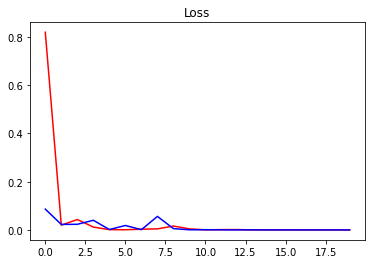

In [28]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

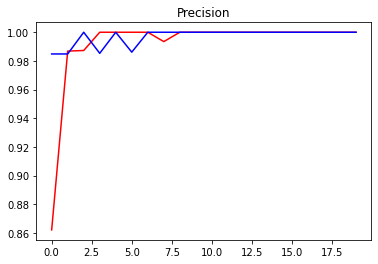

In [29]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

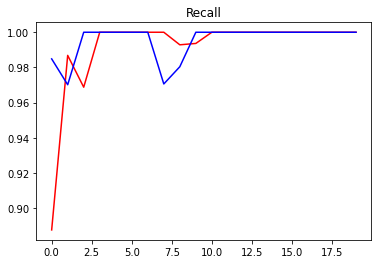

In [30]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [31]:
X_test, y_test = test.as_numpy_iterator().next()

In [32]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 102ms/step


## 8.2 Convert Logits to Classes 

In [33]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [34]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [35]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [36]:
wav = load_mp3_16k_mono(mp3)

In [37]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [38]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [39]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [40]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(32)

In [41]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

6/6 [==============================] - 2s 143ms/step


## 9.4 Group Consecutive Detections

In [42]:
from itertools import groupby

In [43]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [44]:
calls

6

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [46]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(32)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

2/2 [==============================] - 0s 45ms/step


In [47]:
results

{'recording_00.mp3': array([[6.15928788e-03],
        [1.04811494e-04],
        [1.08882203e-03],
        [9.99997377e-01],
        [1.00000000e+00],
        [3.35493122e-09],
        [2.36777210e-04],
        [1.56364476e-04],
        [6.21487416e-05],
        [4.49174782e-03],
        [4.24896542e-04],
        [4.31046169e-03],
        [1.79647996e-05],
        [1.00000000e+00],
        [1.00000000e+00],
        [3.94853014e-05],
        [1.82160884e-11],
        [3.55401862e-05],
        [9.11323004e-04],
        [2.13967054e-03],
        [7.56523688e-04],
        [1.74654706e-04],
        [1.23484638e-02],
        [9.99430835e-01],
        [1.00000000e+00],
        [3.16896426e-10],
        [2.94650454e-06],
        [6.84821047e-04],
        [3.89405486e-08],
        [2.00671097e-03],
        [1.17374431e-04],
        [2.74510272e-02],
        [1.27106086e-05],
        [9.46538762e-07],
        [6.56796945e-03],
        [2.45085103e-05],
        [1.00000000e+00],
        [9.2413828

## 10.2 Convert Predictions into Classes

In [48]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

## 10.3 Group Consecutive Detections

In [49]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 6,
 'recording_05.mp3': 0,
 'recording_06.mp3': 7,
 'recording_07.mp3': 2,
 'recording_08.mp3': 25,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 1,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 5,
 'recording_17.mp3': 5,
 'recording_18.mp3': 3,
 'recording_19.mp3': 2,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 2,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 5,
 'recording_29.mp3': 0,
 'recording_30.mp3': 3,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_38.mp3': 2,
 'recording_39.mp3': 2,
 'recording_40.mp3': 1,
 'recording_41.

# 11. Export Results

In [50]:
import csv

In [51]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])